[ref](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
ngpu=0

In [5]:
n_samples = 10**5
n_feats = 25

In [6]:
x = np.random.randn(n_samples, n_feats)
w = np.random.randn(n_feats) * 0.1
y = x.dot(w) + np.random.randn(n_samples)

### Simple Linear Regression check

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x, y)
reg.coef_

array([-0.04376399, -0.03945602, -0.17605208,  0.00754971, -0.12384144,
        0.01079154,  0.13190117, -0.06264162, -0.10363335,  0.06521167,
        0.07665753,  0.18421801, -0.00393811,  0.06647259, -0.10391695,
        0.10465924, -0.03445056,  0.01081311,  0.09438704, -0.12949015,
        0.17157159,  0.05199782, -0.11250473,  0.19598727,  0.00740792])

In [8]:
reg.score(x, y), (1-reg.score(x, y))*y.var()

(0.2084847080723501, 0.9973204353664029)

# Regress GAN

### Define ANN Architecture

In [9]:
# Batch size during training
batch_size = 64

# Size of z latent vector (i.e. size of generator input)
nz = 5

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [10]:
# create train and test indices
train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
train, val = train_test_split(train, test_size=.25)

In [11]:
# https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X.float32()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()
        else:
            self.y = y.float32()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(x, y=y, scale_X=False)

train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(val))
test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [12]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats+nz, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [14]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear(n_feats+1, network_width, bias=True), # i/p is covariates and o/p
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, network_width, bias=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear( network_width, 1, bias=True),
            nn.Sigmoid(),

        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [16]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [17]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        fake_cpu = torch.hstack((data[0],fake.detach())).to(device)
        output = netD(fake_cpu.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        fake_cpu = torch.hstack((data[0],fake)).to(device)
        output = netD(fake_cpu).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                errD_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    noise = torch.randn(b_size, nz, device=device)
                    # Generate fake image batch with G
                    gen_ip = torch.hstack((data[0],noise)).to(device)
                    gen_op = netG(gen_ip)
                    
                    fake_cpu = torch.hstack((data[0],gen_op)).to(device)
                    fake_output = netD(fake_cpu).view(-1)

                    label.fill_(real_label) # fake labels are real for generator cost
                    errG_val = criterion(output, label)  
                    
                    label.fill_(fake_label)
                    errD_fake_val = criterion(output, label)
                    
                    real_cpu = torch.hstack((data[0],data[1].unsqueeze(1))).to(device)
                    real_output = netD(real_cpu).view(-1)
                    
                    label.fill_(real_label)
                    errD_real_val = criterion(output, label)
                    
                    errG_vals.append(errG_val.item())
                    errD_vals.append((errD_fake_val+errD_real_val).item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
            D_losses_val.append(sum(errD_vals)/len(errD_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_set)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/10][0/938]	Loss_D: 1.3868	Loss_G: 0.6824	D(x): 0.4995	D(G(z)): 0.4990 / 0.5055
[0/10][500/938]	Loss_D: 1.3762	Loss_G: 0.7222	D(x): 0.4958	D(G(z)): 0.4887 / 0.4870
[1/10][0/938]	Loss_D: 1.3770	Loss_G: 0.6908	D(x): 0.5086	D(G(z)): 0.5021 / 0.5019
[1/10][500/938]	Loss_D: 1.3920	Loss_G: 0.6919	D(x): 0.5009	D(G(z)): 0.5035 / 0.5007
[2/10][0/938]	Loss_D: 1.3866	Loss_G: 0.6727	D(x): 0.5111	D(G(z)): 0.5110 / 0.5104
[2/10][500/938]	Loss_D: 1.3865	Loss_G: 0.6920	D(x): 0.4999	D(G(z)): 0.4999 / 0.5006
[3/10][0/938]	Loss_D: 1.3881	Loss_G: 0.6946	D(x): 0.4971	D(G(z)): 0.4979 / 0.4993
[3/10][500/938]	Loss_D: 1.3875	Loss_G: 0.6899	D(x): 0.5006	D(G(z)): 0.5012 / 0.5016
[4/10][0/938]	Loss_D: 1.4027	Loss_G: 0.6809	D(x): 0.5012	D(G(z)): 0.5088 / 0.5064
[4/10][500/938]	Loss_D: 1.3851	Loss_G: 0.6911	D(x): 0.5020	D(G(z)): 0.5013 / 0.5010
[5/10][0/938]	Loss_D: 1.3864	Loss_G: 0.7049	D(x): 0.4938	D(G(z)): 0.4937 / 0.4942
[5/10][500/938]	Loss_D: 1.3844	Loss_G: 0.6884	D(x): 0.5078	D(G

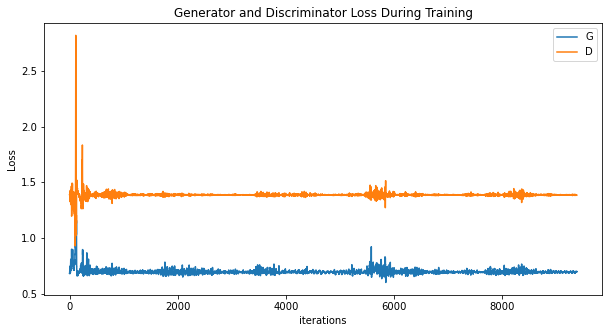

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

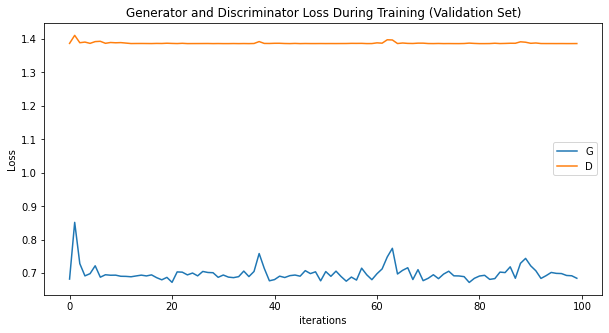

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (Validation Set)")
plt.plot(G_losses_val,label="G")
plt.plot(D_losses_val,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [20]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [21]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [22]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,60000.000000,60000.000000
mean,-0.003363,0.130940
std,1.123513,1.083223
min,-4.497735,-4.093830
25%,-0.768523,-0.552942
50%,-0.004971,0.014632
75%,0.750299,0.801459
max,4.503062,5.248819


In [23]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-4.095000000000001, -1.173]",-0.432133,-1.685144
"(-1.173, -0.716]",-0.262281,-0.925207
"(-0.716, -0.411]",-0.154561,-0.555938
"(-0.411, -0.168]",-0.108099,-0.285671
"(-0.168, 0.0146]",-0.011433,-0.070543
"(0.0146, 0.278]",-0.040945,0.127994
"(0.278, 0.614]",0.108038,0.443452
"(0.614, 1.008]",0.187334,0.803801
"(1.008, 1.579]",0.256541,1.271452


In [24]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(1.9229424, 1.2622803)

In [25]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(1.0997514, 0.89690876)

## Test Predictions

In [26]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        gen_ip = torch.hstack((data[0],noise)).to(device)
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [27]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [28]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,0.004666,0.140507
std,1.122792,1.074249
min,-4.888208,-3.952095
25%,-0.757324,-0.536300
50%,0.008432,0.016732
75%,0.761769,0.809776
max,4.449589,5.012752


In [29]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-3.953, -1.145]",-0.401931,-1.659380
"(-1.145, -0.696]",-0.214597,-0.901030
"(-0.696, -0.393]",-0.170459,-0.537495
"(-0.393, -0.157]",-0.083823,-0.272037
"(-0.157, 0.0167]",-0.063454,-0.064743
"(0.0167, 0.277]",-0.022638,0.129375
"(0.277, 0.626]",0.118965,0.444477
"(0.626, 1.012]",0.186802,0.812570
"(1.012, 1.578]",0.263100,1.272403


In [30]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(1.9200926, 1.2606611)

In [31]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(1.0993619, 0.89594436)

## Test Predictions (averaged)

In [32]:
N_SAMPLES = 100
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        fakes = []
        for _ in range(N_SAMPLES):
            noise = torch.randn(b_size, nz, device=device)
            # Generate fake image batch with G
            gen_ip = torch.hstack((data[0],noise)).to(device)
            fake = netG(gen_ip).detach().cpu().numpy()
            fakes.append(fake)

        test_ops.append(
            (data[1].detach().cpu().numpy(), sum(fakes)/len(fakes))
        )
# print(test_reals.shape,np.concatenate(list(x[0] for x in test_ops)).shape)
# print(test_preds.shape,np.concatenate(list(x[1] for x in test_ops)).shape)
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))


In [33]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,0.004666,0.133966
std,1.122792,0.530682
min,-4.888208,-1.722761
25%,-0.757324,-0.225343
50%,0.008432,0.113609
75%,0.761769,0.475185
max,4.449589,2.496483


In [34]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-1.724, -0.526]",-0.851114,-0.759067
"(-0.526, -0.309]",-0.507051,-0.408216
"(-0.309, -0.156]",-0.318485,-0.227903
"(-0.156, -0.0143]",-0.174075,-0.083116
"(-0.0143, 0.114]",-0.046116,0.049107
"(0.114, 0.249]",0.069400,0.181092
"(0.249, 0.394]",0.240036,0.320526
"(0.394, 0.563]",0.313004,0.475696
"(0.563, 0.821]",0.473275,0.680027


In [35]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(1.048529, 1.2606611)

In [36]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.81782746, 0.89594436)

# MSE model

### Define ANN Architecture

In [37]:
# Batch size during training
batch_size = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.002
# lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# width of the network
network_width = 128

In [38]:
# create train and test indices
train, test = train_test_split(list(range(x.shape[0])), test_size=.2)
train, val = train_test_split(train, test_size=.25)

In [39]:
# https://gist.github.com/conormm/5b26a08029b900520bcd6fcd1f5712a0
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X).float()
        else:
            self.X = X.float32()
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y).float()
        else:
            self.y = y.float32()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(x, y=y, scale_X=False)

train_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
val_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(val))
test_set = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))

In [40]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Linear( n_feats, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, network_width, bias=True),
            nn.ReLU(True),

            nn.Linear( network_width, 1, bias=True)

        )

    def forward(self, input):
        return self.main(input)

In [41]:
# Create the generator
netG = Generator(ngpu).to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [42]:
# Initialize MSELoss function
criterion = nn.MSELoss()

# Setup Adam optimizers for G
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [43]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

G_losses_val = []
D_losses_val = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_set, 0):
        
        b_size = data[0].size(0)

        ############################
        # Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label = data[1]  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netG(data[0]).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_set),
                     0, errG.item(), 0, 0, D_G_z2))
                
        # Output validation stats
        if i % 100 == 0:
            with torch.no_grad():
                errG_vals = []
                for i, data in enumerate(val_set, 0):
                    b_size = data[0].size(0)
                    output = netG(data[0]).view(-1)

                    label = data[1] # fake labels are real for generator cost
                    errG_val = criterion(output, label)  

                    errG_vals.append(errG_val.item())
            G_losses_val.append(sum(errG_vals)/len(errG_vals))
        
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
      
        iters += 1

Starting Training Loop...
[0/10][0/938]	Loss_D: 0.0000	Loss_G: 0.9776	D(x): 0.0000	D(G(z)): 0.0000 / 0.0529
[0/10][500/938]	Loss_D: 0.0000	Loss_G: 0.8726	D(x): 0.0000	D(G(z)): 0.0000 / -0.0416
[1/10][0/938]	Loss_D: 0.0000	Loss_G: 1.0277	D(x): 0.0000	D(G(z)): 0.0000 / 0.0847
[1/10][500/938]	Loss_D: 0.0000	Loss_G: 1.2455	D(x): 0.0000	D(G(z)): 0.0000 / -0.1448
[2/10][0/938]	Loss_D: 0.0000	Loss_G: 1.0432	D(x): 0.0000	D(G(z)): 0.0000 / 0.1596
[2/10][500/938]	Loss_D: 0.0000	Loss_G: 1.0697	D(x): 0.0000	D(G(z)): 0.0000 / -0.0596
[3/10][0/938]	Loss_D: 0.0000	Loss_G: 0.7120	D(x): 0.0000	D(G(z)): 0.0000 / -0.0639
[3/10][500/938]	Loss_D: 0.0000	Loss_G: 0.8056	D(x): 0.0000	D(G(z)): 0.0000 / 0.0606
[4/10][0/938]	Loss_D: 0.0000	Loss_G: 1.1177	D(x): 0.0000	D(G(z)): 0.0000 / -0.0133
[4/10][500/938]	Loss_D: 0.0000	Loss_G: 1.0269	D(x): 0.0000	D(G(z)): 0.0000 / -0.0599
[5/10][0/938]	Loss_D: 0.0000	Loss_G: 1.1699	D(x): 0.0000	D(G(z)): 0.0000 / 0.0871
[5/10][500/938]	Loss_D: 0.0000	Loss_G: 1.0999	D(x): 0.00

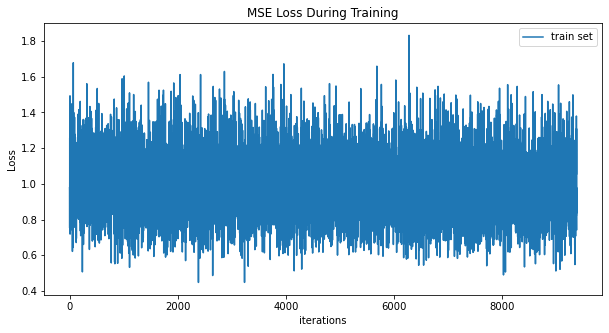

In [44]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
plt.plot(G_losses,label="train set")
# plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

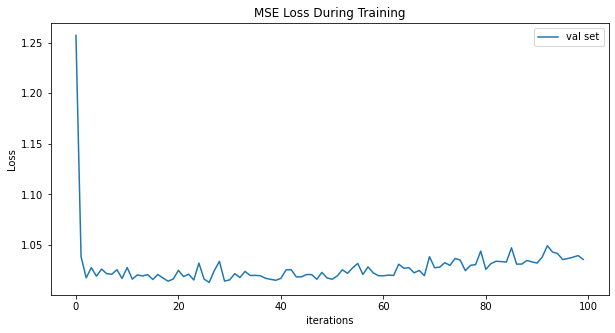

In [45]:
plt.figure(figsize=(10,5))
plt.title("MSE Loss During Training")
# plt.plot(G_losses,label="train set")
plt.plot(G_losses_val,label="val set")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train Predictions

In [46]:
train_ops = []
with torch.no_grad():
    for i, data in enumerate(train_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        fake = netG(data[0])
        
        train_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [47]:
train_reals = np.concatenate(list(x[0] for x in train_ops))
train_preds = np.concatenate(list(x[1] for x in train_ops))

In [48]:
df_results_train = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(train_reals,1),train_preds
    ))
    ,columns = ["true","pred"]
)

df_results_train.describe()

,true,pred
count,60000.000000,60000.000000
mean,0.002643,0.075022
std,1.120057,0.584313
min,-4.888208,-2.231551
25%,-0.758633,-0.324436
50%,0.000750,0.033972
75%,0.758706,0.428532
max,4.166715,3.050315


In [49]:
df_results_train["pred_segment"] = pd.qcut(df_results_train["pred"],10)
df_results_train.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-2.233, -0.637]",-0.968944,-0.872615
"(-0.637, -0.413]",-0.597059,-0.516988
"(-0.413, -0.242]",-0.390369,-0.325616
"(-0.242, -0.0958]",-0.199719,-0.167802
"(-0.0958, 0.034]",-0.054936,-0.030083
"(0.034, 0.178]",0.069166,0.105754
"(0.178, 0.336]",0.202924,0.255183
"(0.336, 0.54]",0.391109,0.432684
"(0.54, 0.842]",0.586956,0.677386


In [50]:
mean_squared_error(df_results_train["true"], df_results_train["pred"]), df_results_train["true"].var()

(0.9497628, 1.2545285)

In [51]:
mean_absolute_error(df_results_train["true"], df_results_train["pred"]), (
    df_results_train["true"]-df_results_train["true"].mean()
).abs().mean()

(0.77657306, 0.894272)

## Test Predictions

In [52]:
test_ops = []
with torch.no_grad():
    for i, data in enumerate(test_set, 0):
        b_size = data[0].size(0)
        # Generate fake image batch with G
        gen_ip = data[0] 
        fake = netG(gen_ip)
        
        test_ops.append(
            (data[1].detach().cpu().numpy(), fake.detach().cpu().numpy())
        )

In [53]:
test_reals = np.concatenate(list(x[0] for x in test_ops))
test_preds = np.concatenate(list(x[1] for x in test_ops))

In [54]:
df_results = pd.DataFrame(
    data = np.hstack((
    np.expand_dims(test_reals,1),test_preds
    ))
    ,columns = ["true","pred"]
)

df_results.describe()

,true,pred
count,20000.000000,20000.000000
mean,-0.012195,0.072027
std,1.123305,0.583928
min,-3.766146,-1.978492
25%,-0.776890,-0.332254
50%,-0.011511,0.039638
75%,0.740055,0.422293
max,4.503062,2.970500


In [55]:
df_results["pred_segment"] = pd.qcut(df_results["pred"],10)
df_results.groupby("pred_segment").mean()

,true,pred
pred_segment,,
"(-1.9789999999999999, -0.65]",-0.851054,-0.875865
"(-0.65, -0.42]",-0.533081,-0.527429
"(-0.42, -0.244]",-0.355034,-0.331675
"(-0.244, -0.0919]",-0.186746,-0.165211
"(-0.0919, 0.0396]",-0.058525,-0.026491
"(0.0396, 0.182]",0.035100,0.111231
"(0.182, 0.332]",0.163248,0.254217
"(0.332, 0.53]",0.337944,0.425126
"(0.53, 0.835]",0.497581,0.665162


In [56]:
mean_squared_error(df_results["true"], df_results["pred"]), df_results["true"].var()

(1.0494852, 1.2618139)

In [57]:
mean_absolute_error(df_results["true"], df_results["pred"]), (
    df_results["true"]-df_results["true"].mean()
).abs().mean()

(0.81760764, 0.89598143)

# Gaussian Process Regression

In [58]:
model = GaussianProcessRegressor(
    kernel=kernels.RBF(length_scale=0.05)
    ,n_restarts_optimizer=10
).fit(x[val], y[val])

In [59]:
model.kernel_.get_params()

{'length_scale': 1.6940550554349076, 'length_scale_bounds': (1e-05, 100000.0)}

In [60]:
y_pred_gauss = model.predict(x[test])
y_true_gauss = y[test]
y_pred_gauss.mean(), y_true_gauss.mean(), y_pred_gauss.std(), y_true_gauss.std()

(-0.01047607552835621,
 -0.01219487639540663,
 0.41172919513124173,
 1.1232767892605249)

In [61]:
mean_absolute_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )
).mean()

(0.8437783243953736, 0.8959814586745866)

In [62]:
mean_squared_error(y_true_gauss, y_pred_gauss), (
    np.abs(
        y_true_gauss-y_true_gauss.mean()
    )**2
).mean()

(1.1180181138074055, 1.2617507452914334)